# Create CIELAB Masks for Fire Detection Dataset

This notebook creates binary masks based on CIELAB color space for fire detection:
1. Convert RGB to CIELAB using skimage
2. Calculate Hue and Chroma from a* and b* values
3. Create binary masks based on Hue and Chroma thresholds
4. Save masks in respective folders

In [13]:
import numpy as np
import cv2
from skimage.color import rgb2lab
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [14]:
# Configure paths
DATASET_PATH = Path('../fire_detection_dataset')

# Create cielab_masks directories in each split
for split in ['train', 'val', 'test']:
    (DATASET_PATH / split / 'cielab_masks').mkdir(exist_ok=True)

In [15]:
def calculate_hue_chroma(a, b):
    """Calculate hue and chroma from a* and b* values.
    
    Args:
        a: a* component from CIELAB
        b: b* component from CIELAB
        
    Returns:
        hue: Hue angle in degrees
        chroma: Color intensity
    """
    # Calculate hue in degrees
    hue = np.degrees(np.arctan2(b, a))
    
    # Ensure hue is in range [-180, 180]
    hue = np.where(hue < -180, hue + 360, hue)
    hue = np.where(hue > 180, hue - 360, hue)
    
    # Calculate chroma
    chroma = np.sqrt(a**2 + b**2)
    
    return hue, chroma

In [16]:
def create_cielab_mask(image, hue_lower=-14.98, hue_upper=96.22, chroma_threshold=6.11):
    """Create binary mask using CIELAB color space.
    
    Args:
        image: RGB image
        hue_lower: Lower hue threshold in degrees
        hue_upper: Upper hue threshold in degrees
        chroma_threshold: Minimum chroma value
        
    Returns:
        Binary mask where fire pixels are 255 and non-fire pixels are 0
    """
    # Convert RGB to LAB
    lab = rgb2lab(image)
    
    # Extract a* and b* components
    a = lab[:, :, 1]
    b = lab[:, :, 2]
    
    # Calculate hue and chroma
    hue, chroma = calculate_hue_chroma(a, b)
    
    # Create binary mask
    mask = np.zeros_like(hue, dtype=np.uint8)
    
    # Apply conditions
    fire_pixels = (hue >= hue_lower) & (hue <= hue_upper) & (chroma >= chroma_threshold)
    mask[fire_pixels] = 255
    
    return mask

In [17]:
def process_dataset():
    """Process all images in the dataset and create CIELAB masks."""
    total_processed = 0
    total_errors = 0
    
    for split in ['train', 'val', 'test']:
        print(f"\nProcessing {split} split...")
        
        # Get all images in the split
        image_paths = list((DATASET_PATH / split / 'images').glob('*.jpg'))
        
        for image_path in tqdm(image_paths):
            try:
                # Read image
                image = cv2.imread(str(image_path))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # Create CIELAB mask
                mask = create_cielab_mask(image)
                
                # Save mask
                output_path = DATASET_PATH / split / 'cielab_masks' / f"{image_path.stem}.png"
                cv2.imwrite(str(output_path), mask)
                
                total_processed += 1
                
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                total_errors += 1
                continue
    
    print(f"\nProcessing completed:")
    print(f"Total images processed: {total_processed}")
    print(f"Total errors: {total_errors}")

In [18]:
def visualize_results(num_samples=3):
    """Visualize some random samples with their masks."""
    for split in ['train', 'val', 'test']:
        print(f"\nVisualization for {split} split:")
        
        # Get all images
        image_paths = list((DATASET_PATH / split / 'images').glob('*.jpg'))
        selected_paths = random.sample(image_paths, min(num_samples, len(image_paths)))
        
        for image_path in selected_paths:
            # Read image and masks
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            original_mask = cv2.imread(str(DATASET_PATH / split / 'masks' / f"{image_path.stem}.png"), 
                                      cv2.IMREAD_GRAYSCALE)
            
            cielab_mask = cv2.imread(str(DATASET_PATH / split / 'cielab_masks' / f"{image_path.stem}.png"), 
                                     cv2.IMREAD_GRAYSCALE)
            
            # Plot
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            fig.suptitle(f'File: {image_path.name}')
            
            axes[0].imshow(image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(original_mask, cmap='gray')
            axes[1].set_title('Ground Truth Mask')
            axes[1].axis('off')
            
            axes[2].imshow(cielab_mask, cmap='gray')
            axes[2].set_title('CIELAB Mask')
            axes[2].axis('off')
            
            plt.tight_layout()
            plt.show()

In [19]:
# Process the dataset
process_dataset()


Processing train split...


100%|██████████| 1645/1645 [00:52<00:00, 31.26it/s]



Processing val split...


100%|██████████| 151/151 [00:04<00:00, 31.56it/s]



Processing test split...


100%|██████████| 207/207 [00:06<00:00, 31.66it/s]


Processing completed:
Total images processed: 2003
Total errors: 0



Visualization for train split:


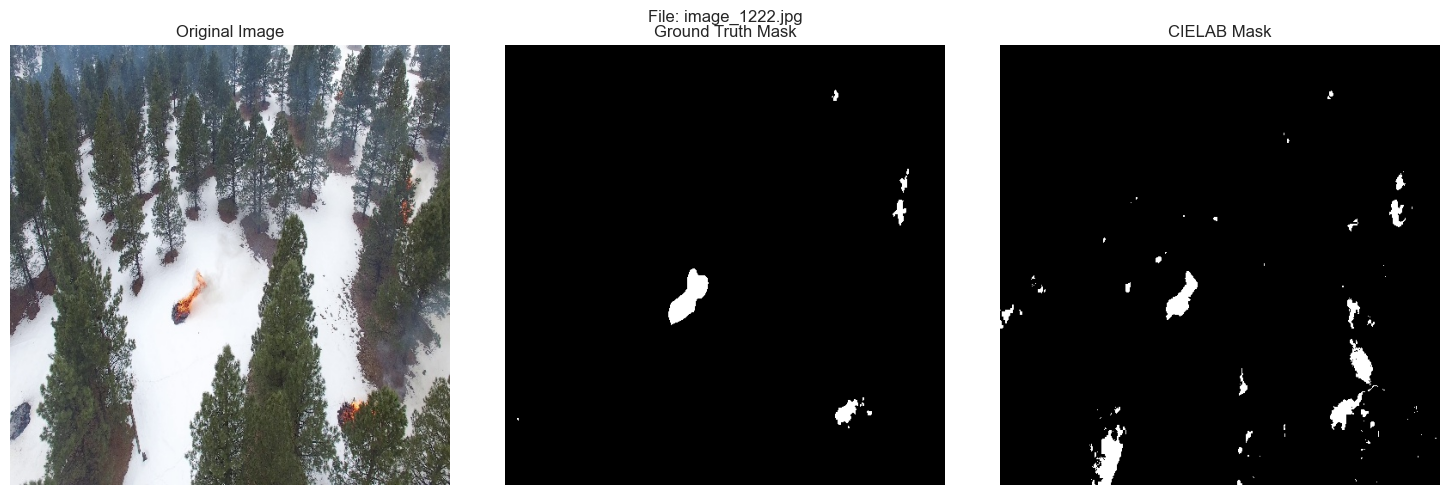

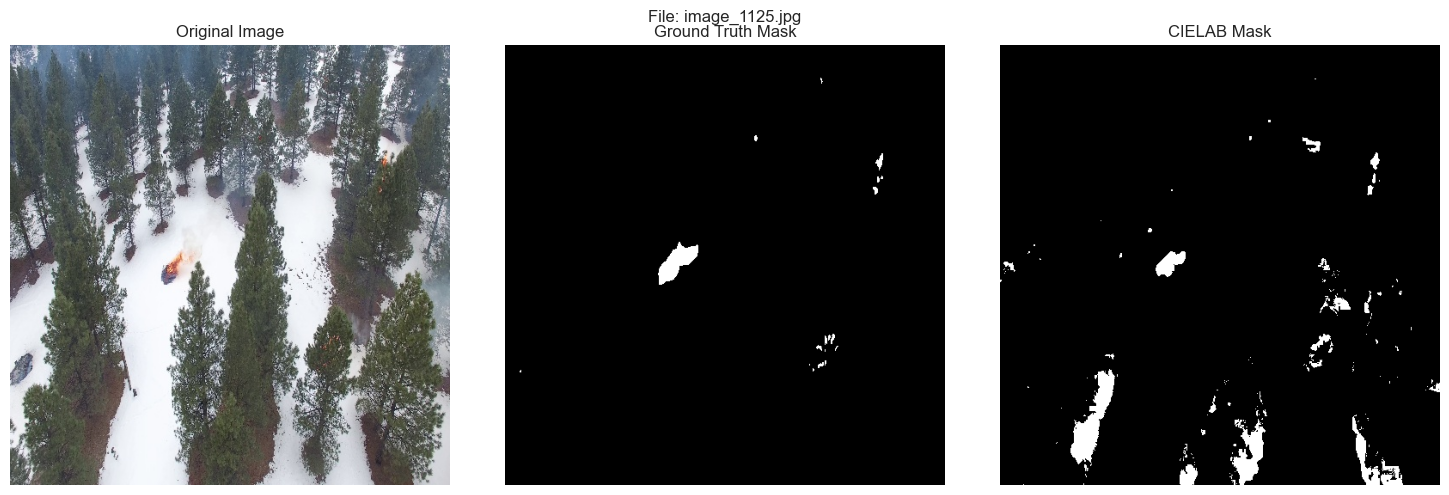

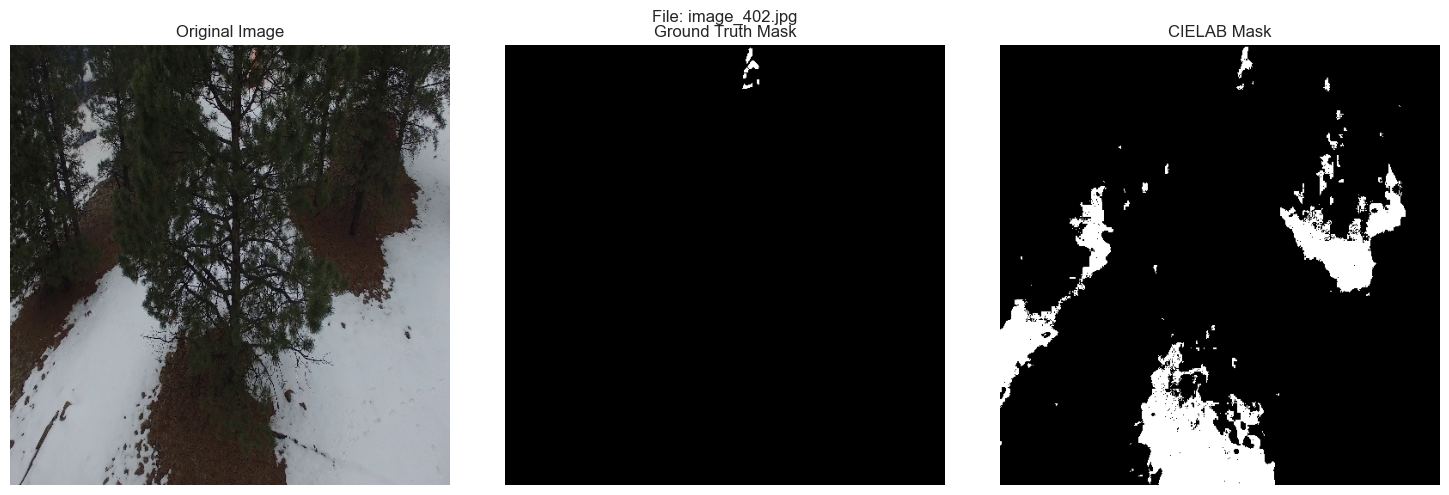


Visualization for val split:


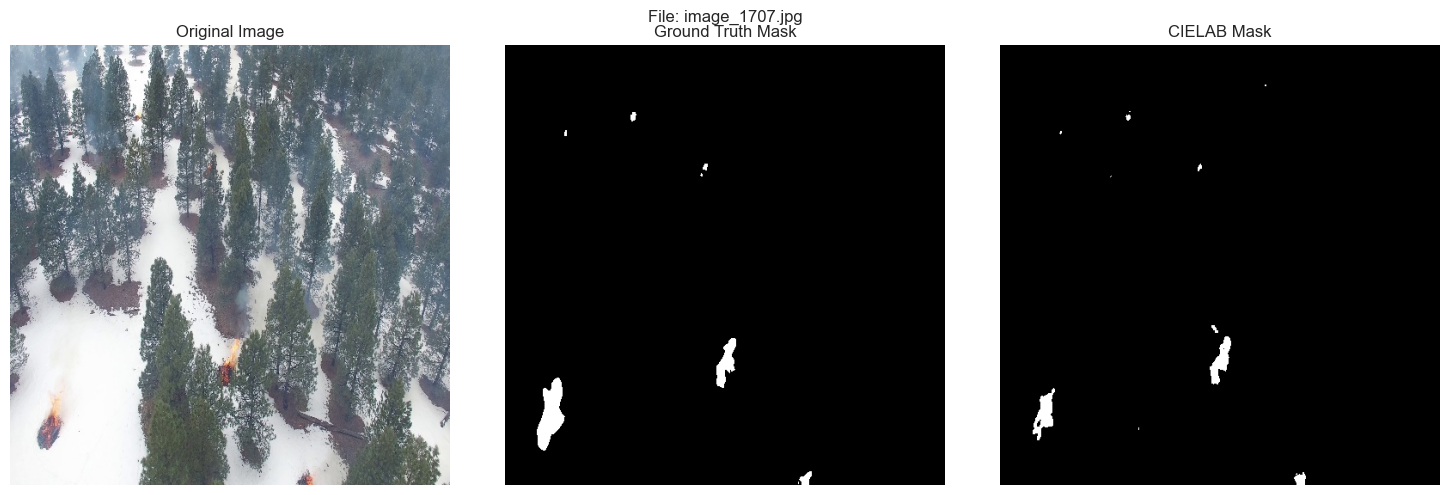

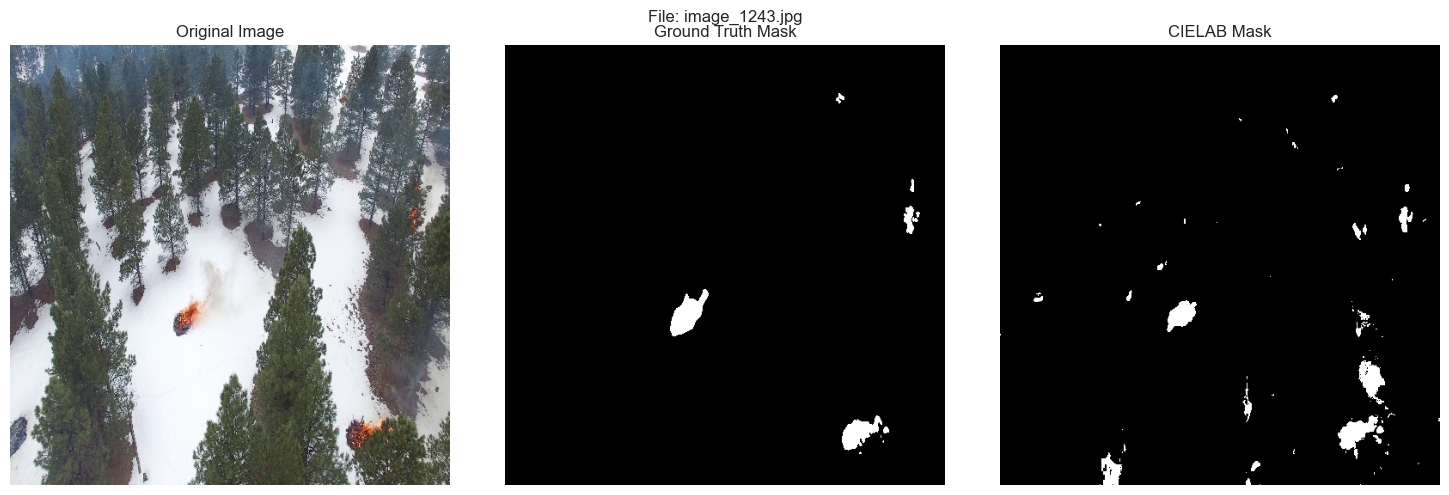

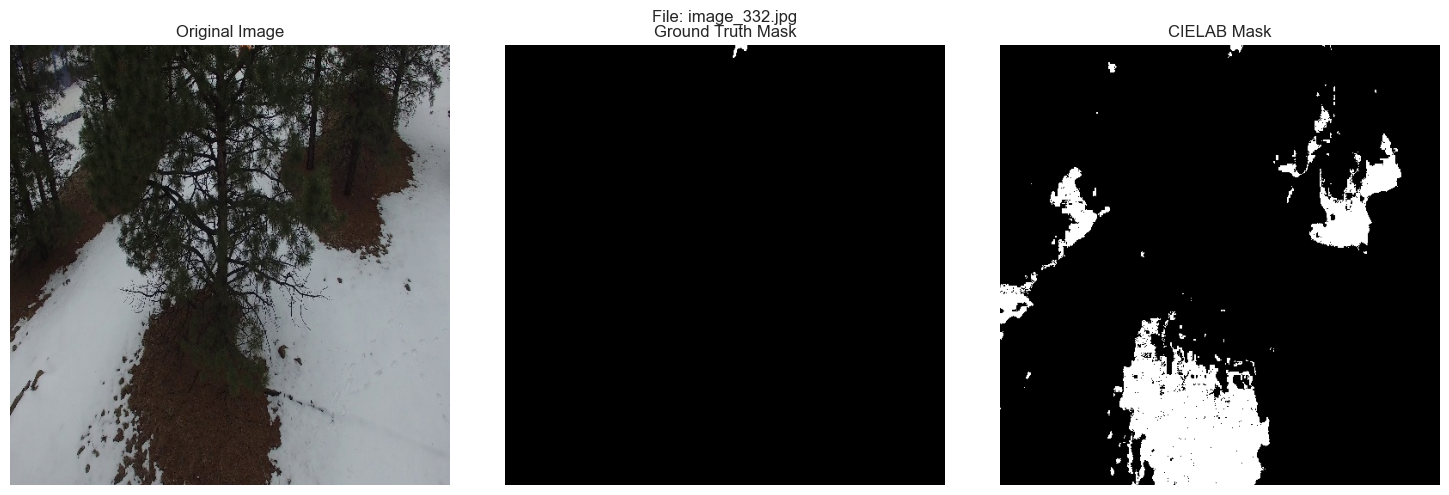


Visualization for test split:


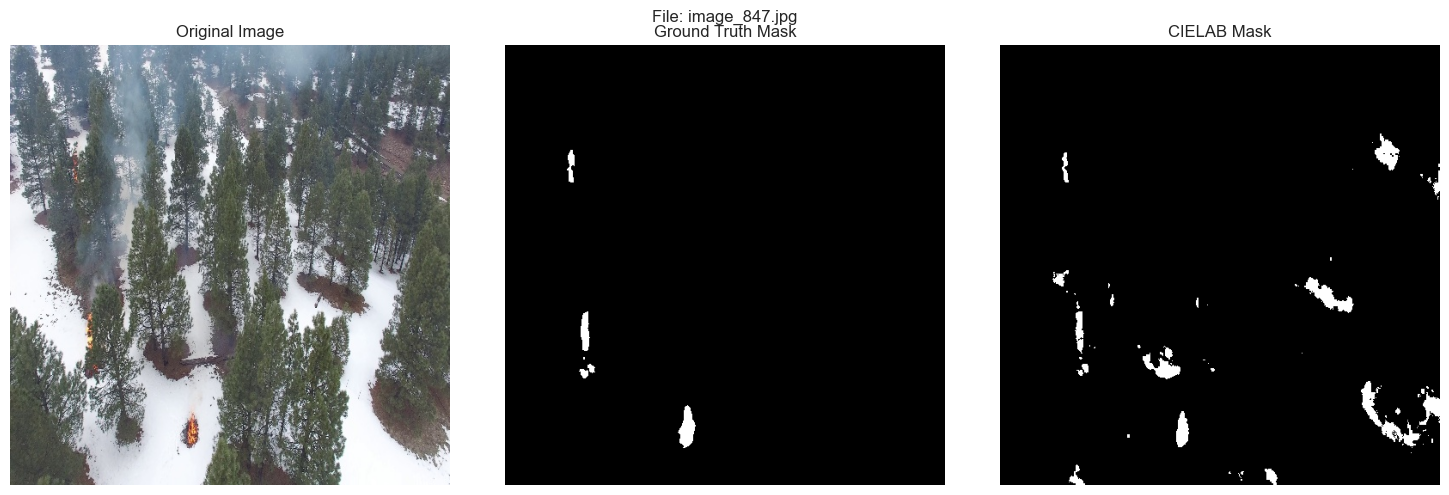

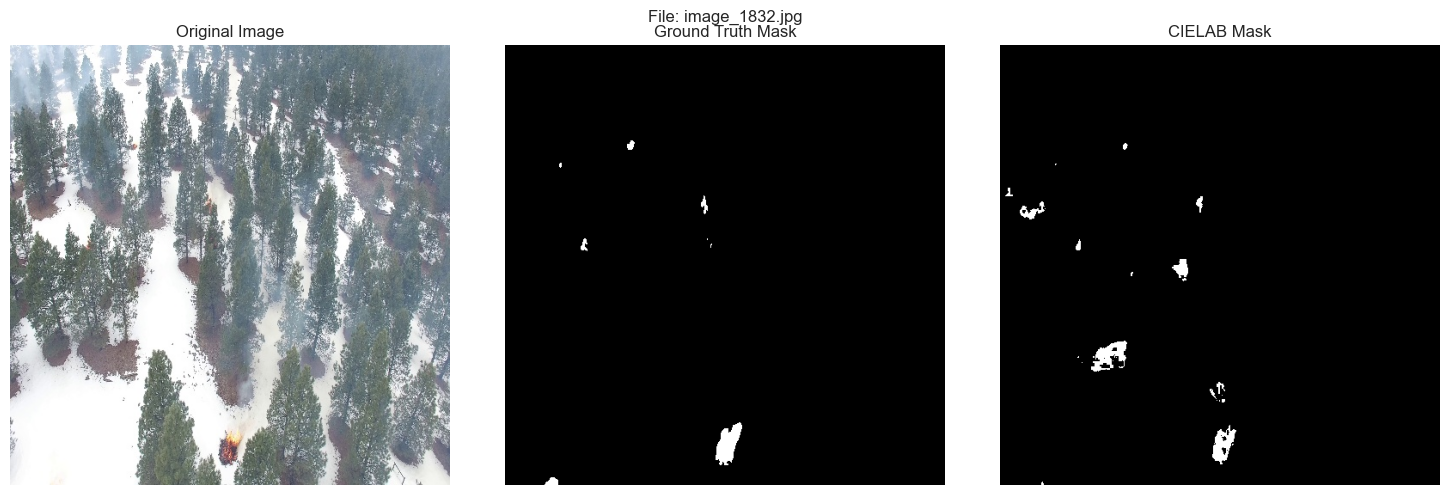

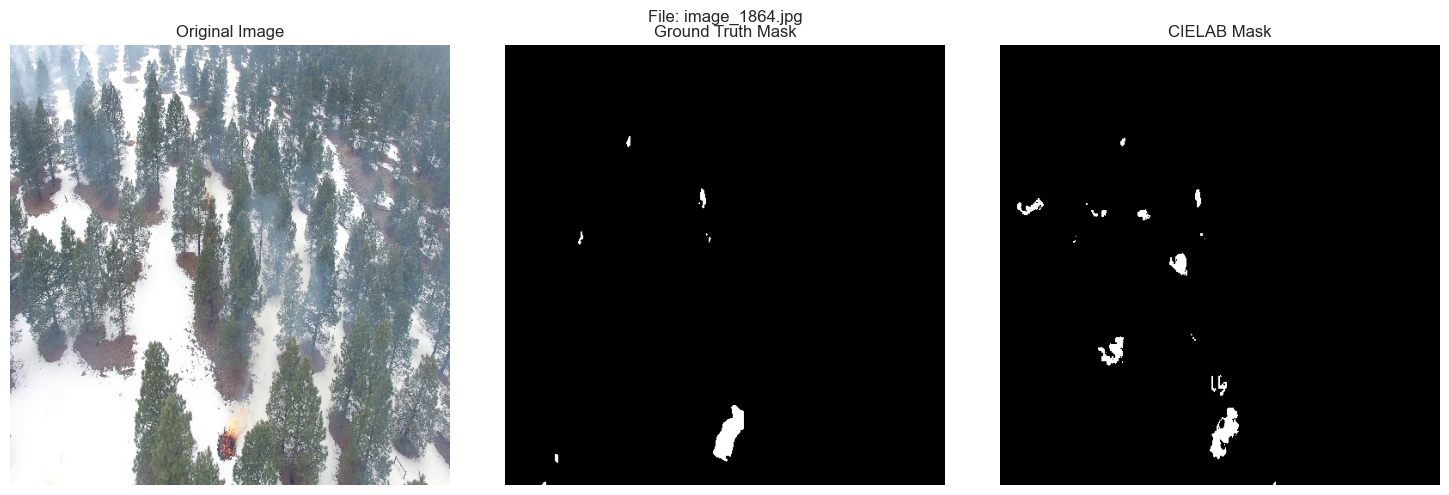

In [20]:
# Visualize some results
visualize_results(num_samples=3)